# Project Swing Vote 
## 1. Import thử viện

In [2]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

## 2. Đọc dữ liệu

In [3]:

# Danh sách các file cổ phiếu
stock_files = [
    "./data/fpt.csv",
    "./data/msn.csv",
    "./data/pnj.csv",
    "./data/vic.csv",
]

# Tạo dictionary để lưu trữ dữ liệu của từng cổ phiếu
stock_data = {}

for file in stock_files:
    # Đọc file và lưu vào dictionary
    stock_name = file.split("/")[-1].replace(".csv", "")  # Lấy tên cổ phiếu từ file
    stock_data[stock_name] = pd.read_csv(file)


In [4]:
stock_data['fpt'].head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


### Ghi chú
- `Open`: Giá mở cửa trong phiên giao dịch
- `High`: Giá cao nhất đạt được trong phiên giao dịch.
- `Low`: Giá thấp nhất đạt được trong phiên giao dịch.
- `Close`: Giá đóng cửa trong phiên giao dịch.
- `Volume`: Khối lượng cổ phiếu được giao dịch.
- `Open Interest`: Lượng hợp đồng phái sinh đang mở (có thể không áp dụng nếu bạn chỉ làm việc với cổ phiếu cơ sở, giá trị ở đây là 0).

## 3. Mô tả dữ liêu


In [5]:
for stock_name in stock_data:
    stock_data[stock_name].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135354 non-null  object 
 1   Date/Time      135354 non-null  object 
 2   Open           135354 non-null  float64
 3   High           135354 non-null  float64
 4   Low  


* Numerical:`Open`,`High`,`Low`,`Close`,`Volume`
* Various Data Type:String,Int,Float

In [6]:
for stock_name in stock_data:
    print(stock_data[stock_name].shape)
    

(97406, 8)
(135354, 8)
(125309, 8)
(101266, 8)


In [7]:
for stock_name in stock_data:
    print(stock_data[stock_name].describe())
    

               Open          High           Low         Close        Volume  \
count  97406.000000  97406.000000  97406.000000  97406.000000  9.740600e+04   
mean      45.071630     45.090138     45.051430     45.071631  8.044173e+03   
std        6.359803      6.364950      6.354245      6.359799  1.753203e+04   
min       30.250000     30.250000     30.220000     30.250000  1.000000e+01   
25%       39.740000     39.740000     39.700000     39.740000  7.500000e+02   
50%       46.950000     46.950000     46.950000     46.950000  2.960000e+03   
75%       49.200000     49.250000     49.170000     49.200000  8.960000e+03   
max       58.400000     58.500000     58.400000     58.400000  1.255930e+06   

       Open Interest  
count        97406.0  
mean             0.0  
std              0.0  
min              0.0  
25%              0.0  
50%              0.0  
75%              0.0  
max              0.0  
                Open           High            Low          Close  \
count  13535

## 4. Tiền sữ lí dữ liệu

In [48]:
def preprocess_stock_data(df):
    # Tiền xử lý từng DataFrame
    df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M')  # Chuyển đổi cột ngày
    df = df.sort_values(by='Date/Time')  # Sắp xếp theo ngày
    return df

# Tiền xử lý cho từng cổ phiếu
for stock_name in stock_data:
    stock_data[stock_name] = preprocess_stock_data(stock_data[stock_name])


In [69]:
key = np.array(list(stock_data.keys()))

In [70]:
key[1]

'msn'

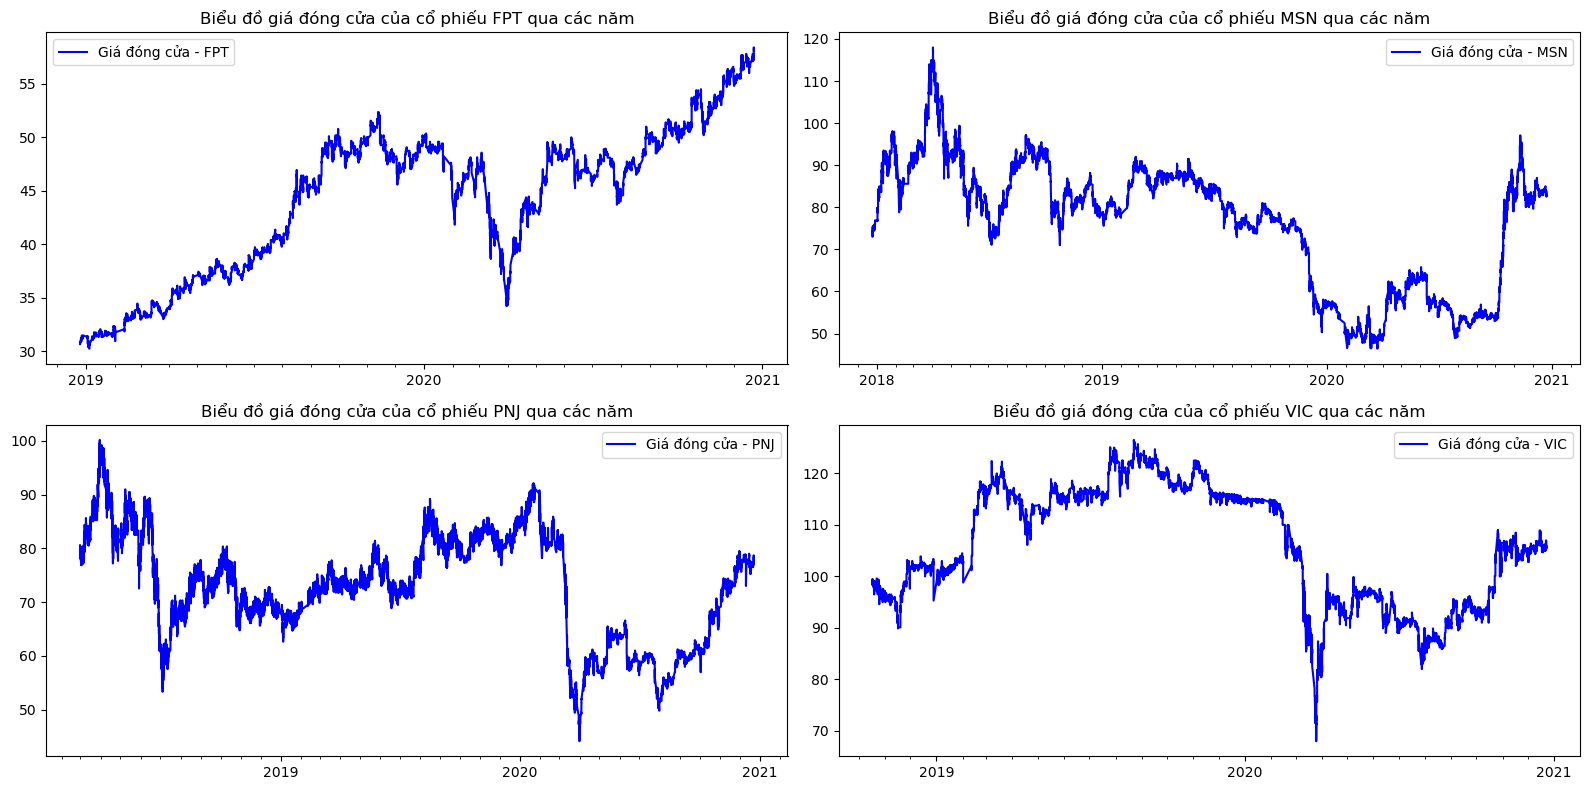

In [75]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

def stock_chart(stock_data):
    n_rows = 2
    n_cols = 2

    fig,ax = plt.subplots(n_rows,n_cols,figsize=(n_cols*8,n_rows*4))
    stock_names = np.array(list(stock_data.keys()))
    for r in range(0,n_rows):
        for c in range(0,n_cols):
            i = r*n_cols + c #index to loop through list "cols"
            stock_name = stock_names[i]
            df = stock_data[stock_name]
            # Lấy thông tin năm từ cột "Ngày"
            df['Year'] = df['Date/Time'].dt.year
            ax_i = ax[r,c]
            ax_i.set_title(f'Biểu đồ giá đóng cửa của cổ phiếu {str.upper(stock_name)} qua các năm')
            # Tạo đồ thị giá đóng cửa qua các năm
            ax_i.plot(df['Date/Time'], df['Close'], label=f'Giá đóng cửa - {str.upper(stock_name)}',color='blue')
            # Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
            years = YearLocator()
            yearsFmt = DateFormatter('%Y')
            months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
            # Định dạng trục thời gian
            ax_i.xaxis.set_major_locator(years)
            ax_i.xaxis.set_major_formatter(yearsFmt)
            ax_i.xaxis.set_minor_locator(months)
            ax_i.legend(loc='best')
    
    plt.tight_layout()
 
stock_chart(stock_data)    

In [35]:
stock_data['fpt']['Close'].values.reshape(-1,1)

array([[30.89],
       [30.81],
       [30.74],
       ...,
       [58.2 ],
       [58.1 ],
       [58.1 ]])

In [37]:
scalers = {}
scaled_data = {}
# Chuẩn hóa sữ liệu
def data_normalization(df,stock_name):
    scaler = MinMaxScaler(feature_range=(0,1))
    scalers[stock_name] = scaler  # Lưu scaler theo tên cổ phiếu
    return scaler.fit_transform(df['Close'].values.reshape(-1, 1) )
for stock_name in stock_data:
    scaled_data[stock_name] = data_normalization(stock_data[stock_name],stock_name)

In [39]:
# Tạo tập dữ liệu cho LSTM
def create_dataset(data, time_step=50):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

X,y = {},{}
time_step = 50
for stock_name in stock_data:
    X[stock_name],y[stock_name] = create_dataset(scaled_data[stock_name],time_step)


In [40]:
# Chia train/test
def split_train_text(X,y):
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train,y_train,X_test,y_test

# Khao báo X_train,y_train
X_train,y_train,X_test,y_test = {},{},{},{}    
for stock_name in stock_data:
    X_train[stock_name],y_train[stock_name],X_test[stock_name],y_test[stock_name] = split_train_text(X[stock_name],y[stock_name])

## Bước 5: Xây dựng và huấn luyện mô hình

In [13]:
from keras.layers import Input

model = {}

# Xây dựng mô hình 
def model_building(X_train):
    model = Sequential([
        Input(shape=(X_train.shape[1],1)),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

for stock_name in stock_data:
    model[stock_name] = model_building(X_train[stock_name])

In [74]:
#huấn luyện mô hình
from tensorflow.keras.callbacks import ModelCheckpoint

def model_training(stock_name,model,X_train,y_train):
    # Tạo callback để lưu mô hình tốt nhất
    checkpoint = ModelCheckpoint(
        f'best_{stock_name}.keras',       # Tên file để lưu
        monitor='loss',        # Theo dõi loss (hoặc 'val_loss' nếu có validation set)
        save_best_only=True,   # Chỉ lưu khi model tốt hơn checkpoint trước
        mode='min',            # Với loss nhỏ hơn là tốt hơn
        verbose=1              # In ra log khi model được lưu
    )
    sample_size = int(0.06 * len(X_train))  # Chuyển float thành integer
    # Huấn luyện model với callback
    model.fit(X_train[:sample_size], y_train[:sample_size], epochs=32, batch_size=50, verbose=2, callbacks=[checkpoint])
    
for stock_name in stock_data:
    model_name = model[stock_name]
    X_train_name = X_train[stock_name]
    y_train_name = y_train[stock_name]
    model_training(stock_name,model_name,X_train_name,y_train_name)


Epoch 1/32

Epoch 1: loss improved from inf to 0.00001, saving model to best_fpt.keras
94/94 - 6s - 68ms/step - loss: 1.4248e-05
Epoch 2/32

Epoch 2: loss improved from 0.00001 to 0.00001, saving model to best_fpt.keras
94/94 - 6s - 68ms/step - loss: 1.0489e-05
Epoch 3/32

Epoch 3: loss improved from 0.00001 to 0.00001, saving model to best_fpt.keras
94/94 - 9s - 96ms/step - loss: 1.0070e-05
Epoch 4/32

Epoch 4: loss improved from 0.00001 to 0.00001, saving model to best_fpt.keras
94/94 - 6s - 64ms/step - loss: 9.1206e-06
Epoch 5/32

Epoch 5: loss did not improve from 0.00001
94/94 - 9s - 100ms/step - loss: 9.4838e-06
Epoch 6/32

Epoch 6: loss did not improve from 0.00001
94/94 - 6s - 62ms/step - loss: 9.2304e-06
Epoch 7/32

Epoch 7: loss improved from 0.00001 to 0.00001, saving model to best_fpt.keras
94/94 - 10s - 104ms/step - loss: 9.0320e-06
Epoch 8/32

Epoch 8: loss did not improve from 0.00001
94/94 - 10s - 109ms/step - loss: 9.2648e-06
Epoch 9/32

Epoch 9: loss improved from 0.0

In [80]:
y_train_predict = {}

def predict_data(x_train,stock_name):
    # Tải lại model tốt nhất
    best_model = load_model(f'best_{stock_name}.keras')
    y_train_predict = best_model.predict(x_train)
    y_train_predict = scalers[stock_name].inverse_transform(y_train_predict)
    return y_train_predict
for stock_name in stock_data:
    X_train_name = X_train[stock_name]
    y_train_predict[stock_name] = predict_data(X_train_name,stock_name)

2434/2434 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 72s 21ms/step
3132/3132 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step
2531/2531 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step


## Bước 6: Sữ dụng mô hình

In [79]:
y_test_predict ={}

# Dự đoán giá X_test
def predict_data_test(X_test,stock_name):
    # Tải lại model tốt nhất
    best_model = load_model(f'best_{stock_name}.keras')
    y_test_predict = best_model.predict(X_test)
    y_test_predict = scalers[stock_name].inverse_transform(y_test_predict)
    return y_test_predict

for stock_name in stock_data:
    X_test_name = X_test[stock_name]
    y_test_predict[stock_name] = predict_data_test(X_test_name,stock_name)

609/609 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step
846/846 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step
783/783 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step
633/633 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step


## Bước 7: Độ chính xác của mô hình

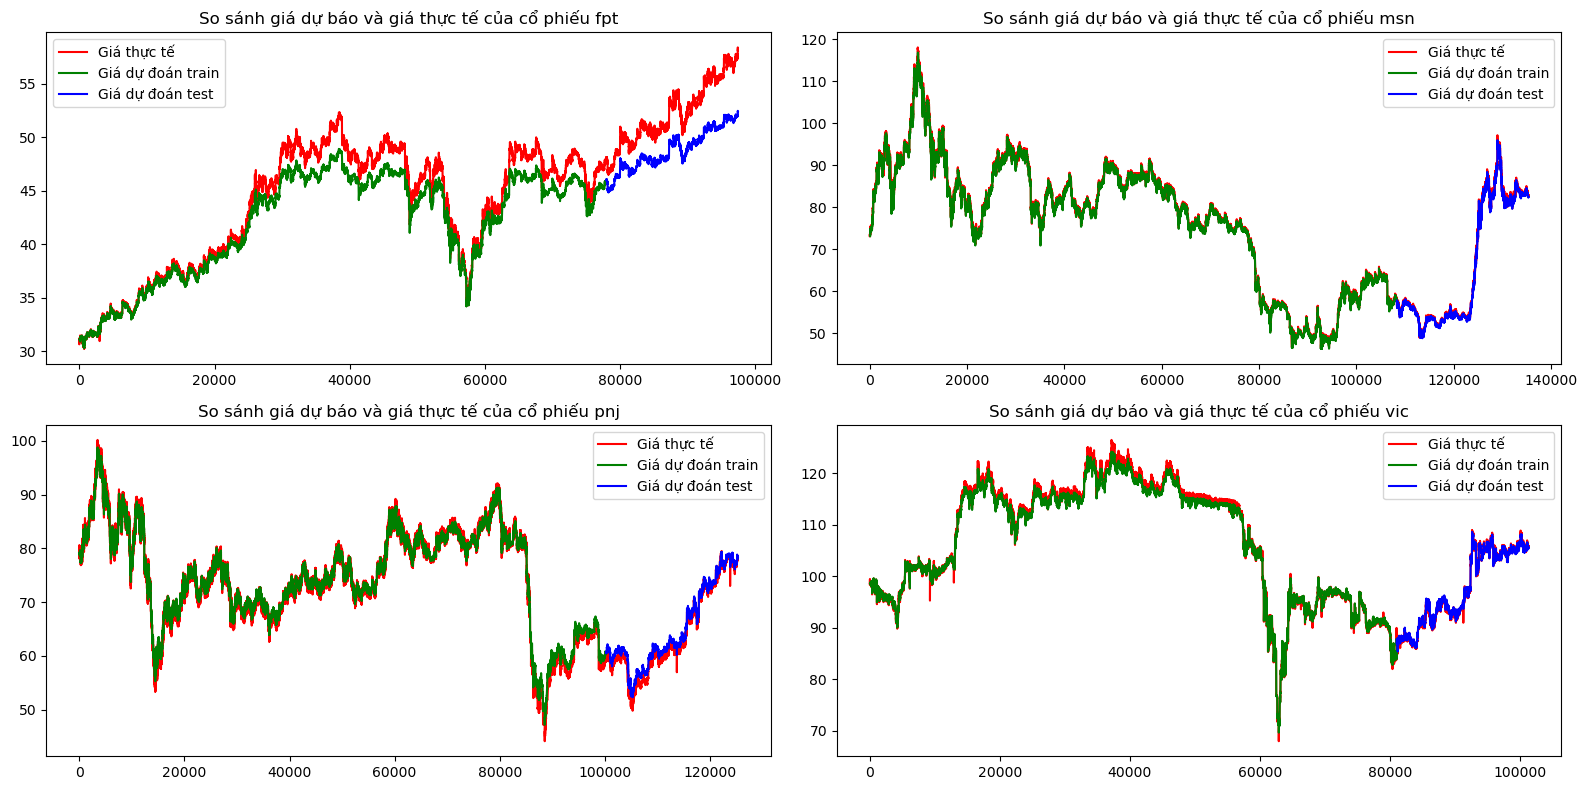

In [87]:
def plot_accuracy_chart(stock_data,y_train_predict,y_test_predict):
    n_rows = 2
    n_cols = 2
    
    fig,ax = plt.subplots(n_rows,n_cols,figsize=(n_cols*8,n_rows*4))
    stock_names = np.array(list(stock_data.keys()))
    for r in range(0,n_rows):
        for c in range(0,n_cols):
            i = r*n_cols + c #index to loop through list "cols"
            stock_name = stock_names[i]
            df = stock_data[stock_name]
            #size
            train_size = y_train_predict[stock_name].size+50
            # Copy data
            train_data = df[50:train_size].copy()
            test_data = df[train_size:].copy()
            # Gán dữ liệu
            train_data['predict'] = y_train_predict[stock_name]
            test_data["predict"] = y_test_predict[stock_name]
            ax_i = ax[r,c]
            ax_i.set_title(f'So sánh giá dự báo và giá thực tế của cổ phiếu {stock_name}')
            # Tạo đồ thị giá đóng cửa qua các năm
            ax_i.plot(df['Close'], label='Giá thực tế', color='red')  # Đường giá thực tế
            ax_i.plot(train_data["predict"], label='Giá dự đoán train', color='green')  # Đường giá dự báo train
            ax_i.plot(test_data["predict"], label='Giá dự đoán test', color='blue')  # Đường giá dự báo test
            ax_i.legend(loc='best')
    
    plt.tight_layout()
plot_accuracy_chart(stock_data,y_train_predict,y_test_predict)

In [89]:
def accuracy_train(y_train,y_train_predict):
     #r2
    print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
    #mae
    print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
    #mae
    print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))
for stock_name in stock_data:
   accuracy_train(y_train[stock_name],y_train_predict[stock_name])
     

Độ phù hợp tập train: -43001.52886554357
Sai số tuyệt đối trung bình trên tập train (VNĐ): 41.52056485108645
Phần trăm sai số tuyệt đối trung bình tập train: 10525187276315.865
Độ phù hợp tập train: -140226.38995381418
Sai số tuyệt đối trung bình trên tập train (VNĐ): 76.3138848417886
Phần trăm sai số tuyệt đối trung bình tập train: 1927461873321.4653
Độ phù hợp tập train: -200087.61181352453
Sai số tuyệt đối trung bình trên tập train (VNĐ): 74.14004597020482
Phần trăm sai số tuyệt đối trung bình tập train: 2144656882729.0176
Độ phù hợp tập train: -287715.864210527
Sai số tuyệt đối trung bình trên tập train (VNĐ): 106.14895818063052
Phần trăm sai số tuyệt đối trung bình tập train: 3958152154482.8525


In [91]:
def accuracy_test(y_test,y_test_predict):
    #r2
    print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
    #mae
    print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
    #mae
    print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))
for stock_name in stock_data:
   accuracy_train(y_test[stock_name],y_test_predict[stock_name])

Độ phù hợp tập train: -217678.21560989995
Sai số tuyệt đối trung bình trên tập train (VNĐ): 48.0405329902987
Phần trăm sai số tuyệt đối trung bình tập train: 62.170943951499886
Độ phù hợp tập train: -110214.44578868104
Sai số tuyệt đối trung bình trên tập train (VNĐ): 65.46303549114926
Phần trăm sai số tuyệt đối trung bình tập train: 375.34935243628826
Độ phù hợp tập train: -213419.25518148037
Sai số tuyệt đối trung bình trên tập train (VNĐ): 64.98852995101875
Phần trăm sai số tuyệt đối trung bình tập train: 203.64626051103147
Độ phù hợp tập train: -638915.1859795164
Sai số tuyệt đối trung bình trên tập train (VNĐ): 97.18311829004442
Phần trăm sai số tuyệt đối trung bình tập train: 200.15577767343646
